In [1]:
# %tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf
print(tf.__version__)
import matplotlib
# matplotlib.use('TKAgg')
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
PROJECT_DIR = "../../"

2022-09-01 02:51:36.325878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 02:51:36.325912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


## Helper class

In [2]:
class Helper:
    import numpy as np

    def make_fine_grid(self,raw_data, n_corse_x = 3, n_corse_y = 5, n_fine_x = 30, n_fine_y = 80):
        listFG = []  # List Fine Grid
        N = len(raw_data)
        for i in range(N):
            print(f"Pre Processing {i+1:05d}/{N}, {100*(i+1)//N}%",end="\r")
            kirigami_config = raw_data[i, 0:15]
            inner_wCuts = self.corse_to_fine_config(
                kirigami_config, n_corse_x, n_corse_y, n_fine_x, n_fine_y)
            listFG.append(inner_wCuts)

        alldata_FG = np.array(listFG)
        alldata_FG = np.append(alldata_FG, raw_data[:, -3:], 1)
        return alldata_FG

    def corse_to_fine_config(self,kirigami_config, n_corse_x, n_corse_y, n_fine_x, n_fine_y):
        """
        Make Fine Grid using corse grid
        0 5 10     0  80  160 ... 2320
        1 6 11     .  .    .  ... .
        2 7 12  => .  .    .  ... .
        3 8 13     .  .    .  ... .
        4 9 14     79 159 239 ... 2399

        Parameters
        --------------------
        kirigami_config: Corse Kirigami config of size n_corse_x * n_corse_y
        return: Fine grid 1D array of size n_fine_x*n_fine_y
        """
        fine_grid = np.ones((n_fine_x,n_fine_y))
        mx, my = n_fine_x//n_corse_x, n_fine_y//n_corse_y  # 10 16
        zeros = np.array([1]*mx)[:,np.newaxis]
        zeros[mx//3:2*mx//3+1]=0
        # ONLY MAKE CUTS inside the INNER REGION !!
        for index,num in enumerate(kirigami_config):
            if num == 0:
                i_corse_x = index // n_corse_y
                i_corse_y = index % n_corse_y
                fine_grid[mx*i_corse_x:mx*(i_corse_x+1),my*i_corse_y:my*(i_corse_y+1)] = zeros
        return fine_grid.flatten()

    def split_data(self,x, y, frac_training, frac_test):
        """
        Parameters
        ----------------------------
        x: numpy matrix 
        y: numpy array
        percentage_test: float 
            percentage of data to be set for test set
        Return
        -------------------
        X_train, X_valid, X_test, y_train, y_valid, y_test

        """
        frac_valid = 1 - frac_training - frac_test
        ntrain = int(frac_training * len(x))
        nvalid = int(frac_valid * len(x))
        # ntest = int(frac_test * len(x))

        X_train = x[:ntrain].reshape((-1,30,80,1))
        X_valid = x[ntrain:ntrain+nvalid].reshape((-1,30,80,1))
        X_test = x[ntrain+nvalid:].reshape((-1,30,80,1))

        y_train = y[:ntrain]
        y_valid = y[ntrain:ntrain+nvalid]
        y_test =  y[ntrain+nvalid:]
        # [:,np.newaxis] to convert it to column array
        return X_train, X_valid, X_test, y_train[:,np.newaxis], y_valid[:,np.newaxis], y_test[:,np.newaxis]
helper = Helper()

## Prepare Dataset
We conver coarse grid data to fine grid data using helper class

In [3]:
alldata_15G = np.loadtxt(f'{PROJECT_DIR}/raw/alldata_15G.dat')
alldata_FG  = helper.make_fine_grid(alldata_15G)
# Shuffle the data althought not needed as it is already suffled
# np.random.shuffle(alldata_FG)

## Split Test Train

In [4]:
__FEATURES = len(alldata_FG[0])-3
__PROP_INDEX = -1  # -3: Strain, -1: Stress 
print("No of featues:",__FEATURES,"\nProperty index:",__PROP_INDEX)
__PROP_DATA = alldata_FG[:,__PROP_INDEX]
__MAX_PROP = np.max(__PROP_DATA)
print("Max Prop",__MAX_PROP)
__PROP_DATA /= np.max(__PROP_DATA)  # Rescale 0 to 1
X_train, X_valid, X_test, y_train, y_valid, y_test = helper.split_data(alldata_FG[:,0:__FEATURES], __PROP_DATA, 0.8, 0.1)
print("Training",len(X_train))
print("Validation",len(X_valid))
print("Tesing",len(X_test))
print(X_train.shape,y_train.shape)

No of featues: 2400 
Property index: -1
Max Prop 107.9651
Training 23832
Validation 2979
Tesing 2980
(23832, 30, 80, 1) (23832, 1)


## Regression Model

In [5]:
n_hidden=64
model = models.Sequential()
# Filters:16, Kernal:3x3
model.add(layers.Conv2D(
    input_shape = (30,80,1),
    filters = 16,
    kernel_size = [3,3],
    padding="same",
    activation="relu"))
# Max Pooling, kernel:2x2, strides:2 
model.add(layers.MaxPooling2D((2,2),2))
# Filters:32, Kernal:3x3
model.add(layers.Conv2D(32,(3,3),activation="relu"))
# Max Pooling, kernel:2x2, strides:2 
model.add(layers.MaxPooling2D((2,2),2))
# Filters:64, Kernal:3x3
model.add(layers.Conv2D(64,(3,3),activation="relu"))
# Max Pooling, kernel:2x2, strides:2 
model.add(layers.MaxPooling2D((2,2),2))

# Flatten for the fully connected layer
model.add(layers.Flatten())
# Fully connected layer 64:Neuron
model.add(layers.Dense(n_hidden,activation="relu"))
model.add(layers.Dense(1,activation="linear"))

2022-09-01 02:51:49.334934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 02:51:49.335191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-01 02:51:49.335353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-01 02:51:49.335504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-09-01 02:51:49.335652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 80, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 38, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 19, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 17, 64)         18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 8, 64)         0

In [7]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model.fit(X_train, y_train, batch_size=200,epochs=30, 
                    validation_data=(X_valid, y_valid))
model.save(f"./models/01-regression/stress-f16-f32-f64-h{n_hidden}")

Epoch 1/30
120/120 [==============================] - 4s 29ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2/30
120/120 [==============================] - 4s 33ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/30
120/120 [==============================] - 3s 29ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/30
120/120 [==============================] - 3s 28ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/30
120/120 [==============================] - 3s 29ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/30
120/120 [==============================] - 3s 28ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/30
120/120 [==

INFO:tensorflow:Assets written to: ./models/01-regression/stress-f16-f32-f64-h64/assets


INFO:tensorflow:Assets written to: ./models/01-regression/stress-f16-f32-f64-h64/assets


## Load the saved model

In [8]:
# model = models.load_model(f"./models/01-regression/stress-f16-f32-f64-h{n_hidden}")

In [9]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2


mse_train = tf.keras.metrics.mean_squared_error(
    y_train, model.predict(X_train)
)
r2_train = R_squared(
    y_train, model.predict(X_train)
)


mse_val = tf.keras.metrics.mean_squared_error(
    y_valid, model.predict(X_valid)
)
r2_val = R_squared(
    y_valid, model.predict(X_valid)
)


mse_test = tf.keras.metrics.mean_squared_error(
    y_test, model.predict(X_test)
)
r2_test = R_squared(
    y_test, model.predict(X_test)
)
print(len(mse_train))
train_stats=f"Train: RMSE: {np.sqrt(np.mean(mse_train))*__MAX_PROP:0.2f}, R2: {np.mean(r2_train):0.2f}"
validation_stats=f"Valid.:- RMSE: {np.sqrt(np.mean(mse_val))*__MAX_PROP:0.2f}, R2: {np.mean(r2_val):0.2f}"
test_stats=f"Test:- RMSE: {np.sqrt(np.mean(mse_test))*__MAX_PROP:0.2f}, R2: {np.mean(r2_test):0.2f}"
print(train_stats)
print(validation_stats)
print(test_stats)
y_pred = model.predict(X_test)
xx = y_pred.flatten()
yy = y_test.flatten()
#plt.plot([0,1],[1,0])

94/94 [==============================] - 0s 4ms/step
23832
Train: RMSE: 2.80, R2: 0.97
Valid.:- RMSE: 2.91, R2: 0.97
Test:- RMSE: 2.96, R2: 0.97
94/94 [==============================] - 0s 4ms/step


94/94 [==============================] - 0s 4ms/step


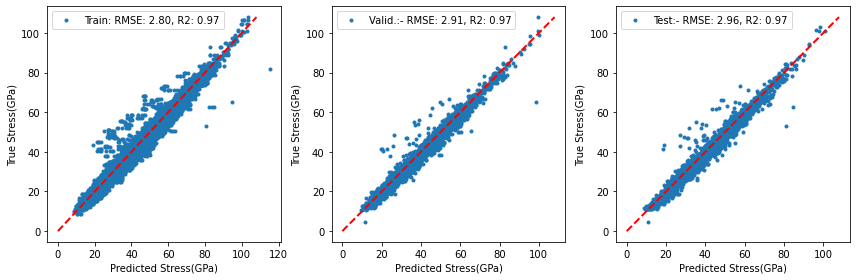

In [10]:
y_pred = model.predict(X_test)
xx = y_pred.flatten()
yy = y_test.flatten()
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
fig.set_size_inches(12,4)
ax1.plot( model.predict(X_train).flatten()*__MAX_PROP,y_train.flatten()*__MAX_PROP,".",label=train_stats)
ax2.plot( model.predict(X_valid).flatten()*__MAX_PROP,y_valid.flatten()*__MAX_PROP,".",label=validation_stats)
ax3.plot( model.predict(X_test).flatten()*__MAX_PROP,y_test.flatten()*__MAX_PROP,".",label=test_stats)

for ax in (ax1,ax2,ax3):
    ax.plot([0,__MAX_PROP],[0,__MAX_PROP],"r--",lw=2.0)
    ax.legend()
    ax.set_xlabel("Predicted Stress(GPa)")
    ax.set_ylabel("True Stress(GPa)")
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])
plt.tight_layout()
plt.savefig("./results/01-regression-stress.png",dpi=300)
plt.show()